In [47]:
import numpy as np
import cv2
import tensorflow as tf

In [48]:
face_detection_model=cv2.dnn.readNetFromCaffe('/content/drive/MyDrive/deploy.prototxt.txt','/content/drive/MyDrive/res10_300x300_ssd_iter_140000.caffemodel')

In [49]:
model=tf.keras.models.load_model('/content/drive/MyDrive/FaceMaskDetectionProject/cnn_modelk6.h5')

In [50]:
labels=['Mask', 'No Mask', 'Covered Mouth and Chin', 'Covered Nose and Mouth']

In [51]:
def Color(label):
    if label=='Mask':
       color=(0,255,0)
    elif label=='No Mask':
       color=(0,0,255)
    elif label=='Covered Mouth Chin':
        color=(0,255,255)
    else:
      color=(255,255,0)

    return color

In [52]:
from scipy.special import softmax

def mask_prediction(img):
    image=img.copy()
    h,w=image.shape[:2]
    blob=cv2.dnn.blobFromImage(image,1,(300,300),(104,117,123),swapRB=True)
    face_detection_model.setInput(blob)
    detection=face_detection_model.forward()
    for i in range(0,detection.shape[2]):
       confidence =detection[0,0,i,2]
       if confidence > 0.5:
          box=detection[0,0,i,3:7]*np.array([w,h,w,h])
          box=box.astype(int)
          pt1=(box[0],box[1])
          pt2=(box[2],box[3])

          face=image[box[1]:box[3],box[0]:box[2]]
          face_blob=cv2.dnn.blobFromImage(face,1,(100,100),(104,117,123),swapRB=True)
          face_blob_squeeze=np.squeeze(face_blob).T
          face_blob_rotate=cv2.rotate(face_blob_squeeze,cv2.ROTATE_90_CLOCKWISE)
          face_blob_flip=cv2.flip(face_blob_rotate,1)

          img_norm=np.maximum(face_blob_flip,0)/face_blob_flip.max()
          img_input=img_norm.reshape(1,100,100,3)
          result=model.predict(img_input)
          result=softmax(result)[0]
          confidence_index=result.argmax()
          confidence_score=result[confidence_index]
          label=labels[confidence_index]
          label_text='{}:{:,.0f}%'.format(label,confidence_score*100)

          color=Color(label)
          cv2.rectangle(image,pt1,pt2,color,1)
          cv2.putText(image,label_text,pt1,cv2.FONT_HERSHEY_PLAIN,2,color,2)
    return image

1/1 [==============================] - 0s 133ms/step


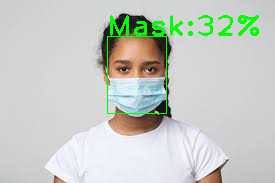

In [53]:
from google.colab.patches import cv2_imshow
import cv2
img=cv2.imread('/content/drive/MyDrive/FaceMaskDetectionProject/download.jpeg')
image=mask_prediction(img)
# 'img' değişkeninizin bir görüntü olduğunu varsayalım
cv2_imshow(image)

In [8]:
!pip install opencv-python

In [ ]:
import cv2
cap=cv2.VideoCapture(0)
while True:
  ret,frames=cap.read()
  if ret==False:
     break
  image=mask_prediction(frames)
  cv2_imshow('Face Mask Prediction',image)
  if cv2.waitKey(1)==27:
    break
cap.release()
cv2.destroyAllWindows()